In [1]:
from matplotlib import pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from model import Informer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
import time

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

epochs = 150
Sequence_length = 240  # Sequence-to-sequence model
enc_in = dec_in = 16
c_out = 1
embed_dim = 480
# n_heads = 9
n_heads = 4
e_layers = 6
d_layers = 4
batch_size = 20
dropout = 0.06
learning_rate = 0.00016
step_size = 40
gamma = 0.233

True


In [3]:
## Data processing
Data = np.loadtxt('D:/Research/5-Deep_Learning/Code for paper/LSTM/ESM/Data_ESM_Paper.csv', delimiter=',', skiprows=0)
# 0: IC WindSpd; 1-23: WindSpd; 24: WaveEle; 25: BldPit; 26: TipDxc1; 27: TipDyc1; 28: TwrTpTDxi; 29: TwrTpTDyi; 30: PtfmTDxi; 31: PtfmTDyi; 32: TwrBsMyt; 33: TwrBsMxt
Name = 'Time'  # uT, uP, MT, MS
print(Data.shape)
Cic = int(120/0.5)  # Length of each simulation
WindSpeed = np.arange(26, 51, 2)  # wind-speed range
IM = len(WindSpeed)

Fea_13 = np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25])
Col = np.append(Fea_13, np.array([0, 26, 27, 28]))

input_size = len(Col) -1
output_size = 1

num_WF = 10*6*3  # Wind fields for each wind speed    TOTAL LENGTH: IM*num_WF*Cic
num_Train = 3*6*3  # Wind fields for each wind speed for training
num_Test = 1*6*3
num_Valid = 1*6*3

Data_Train = np.zeros([num_Train*Cic*IM, len(Col)])
Data_Valid = np.zeros([num_Valid*Cic*IM, len(Col)])
Data_Test = np.zeros([num_Test*Cic*IM, len(Col)])

for i in range(IM):
    Data_Train[num_Train*Cic*i: num_Train*Cic*(i+1), :] = Data[num_WF*Cic*i: num_Train*Cic + num_WF*Cic*i, Col]
    Data_Valid[num_Valid*Cic*i: num_Valid*Cic*(i+1), :] = Data[num_Train*Cic + num_WF*Cic*i: (num_Train+num_Test)*Cic + num_WF*Cic*i, Col]
    Data_Test[num_Test*Cic*i: num_Test*Cic*(i+1), :] = Data[(num_Train+num_Test)*Cic + num_WF*Cic*i: (num_Train+num_Valid+num_Test)*Cic + num_WF*Cic*i, Col]

scaler = MinMaxScaler(feature_range=(0, 1))
X_Train_enc = scaler.fit_transform(Data_Train[:, :-1]).reshape(-1, Sequence_length, input_size)
Y_Train = Data_Train[:, -1].reshape(-1, Sequence_length, output_size)
X_Valid_enc = scaler.transform(Data_Valid[:, :-1]).reshape(-1, Sequence_length, input_size)
Y_Valid = Data_Valid[:, -1].reshape(-1, Sequence_length, output_size)
X_Test_enc = scaler.transform(Data_Test[:, :-1]).reshape(-1, Sequence_length, input_size)
Y_Test = Data_Test[:, -1].reshape(-1, Sequence_length, output_size)

X_Train_dec = np.zeros([X_Train_enc.shape[0], Sequence_length*2, input_size])
X_Train_dec[:, :Sequence_length, :] = X_Train_enc
X_Valid_dec = np.zeros([X_Valid_enc.shape[0], Sequence_length*2, input_size])
X_Valid_dec[:, :Sequence_length, :] = X_Valid_enc
X_Test_dec = np.zeros([X_Test_enc.shape[0], Sequence_length*2, input_size])
X_Test_dec[:, :Sequence_length, :] = X_Test_enc

print(X_Train_enc.shape)
print(X_Valid_enc.shape)
print(X_Test_enc.shape)
print(X_Train_dec.shape)
print(X_Valid_dec.shape)
print(X_Test_dec.shape)
print(Y_Train.shape)
print(Y_Valid.shape)
print(Y_Test.shape)

(561600, 32)
(702, 240, 16)
(234, 240, 16)
(234, 240, 16)
(702, 480, 16)
(234, 480, 16)
(234, 480, 16)
(702, 240, 1)
(234, 240, 1)
(234, 240, 1)


In [4]:
class TensorDataset(Dataset):
    def __init__(self, X_enc, X_dec, Y):
        self.feas_enc = X_enc
        self.feas_dec = X_dec
        self.labs = Y
        self.len = len(self.feas_enc)

    def __getitem__(self, index):
        return self.feas_enc[index], self.feas_dec[index], self.labs[index]

    def __len__(self):
        return self.len

DataSet_train = TensorDataset(X_Train_enc, X_Train_dec, Y_Train)
DataSet_valid = TensorDataset(X_Valid_enc, X_Valid_dec, Y_Valid)
DataSet_test = TensorDataset(X_Test_enc, X_Test_dec, Y_Test)

TrainDataLoader = DataLoader(DataSet_train, batch_size=batch_size, shuffle=True, drop_last=True)
ValidDataLoader = DataLoader(DataSet_valid, batch_size=batch_size, shuffle=True, drop_last=True)
TestDataLoader = DataLoader(DataSet_test, batch_size=batch_size, shuffle=False, drop_last=True)

In [20]:
##训练
model = Informer(enc_in, dec_in, c_out, Sequence_length, embed_dim, n_heads, e_layers, d_layers, dropout).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
criterion = nn.MSELoss().to(device)

In [6]:
def test():
    with torch.no_grad():
        valid_epoch_loss = []
        for inputs_enc, inputs_dec, targets in ValidDataLoader:
            inputs_enc = torch.tensor(inputs_enc).float().to(device)
            inputs_dec = torch.tensor(inputs_dec).float().to(device)
            targets = torch.tensor(targets).float().to(device)
            outputs = model(inputs_enc, inputs_dec)
            loss = criterion(outputs.float(), targets.float())
            valid_epoch_loss.append(loss.item())
    return np.mean(valid_epoch_loss)

In [21]:
valid_loss = []
train_loss = []
best_loss = 1000
start_time = time.time()
print("Training Start")

for epoch in range(epochs):
    train_epoch_loss = []
    for inputs_enc, inputs_dec, targets in TrainDataLoader:
        optimizer.zero_grad()
        inputs_enc = torch.tensor(inputs_enc).float().to(device)
        inputs_dec = torch.tensor(inputs_dec).float().to(device)
        targets = torch.tensor(targets).float().to(device)
        outputs = model(inputs_enc, inputs_dec)
        loss = criterion(outputs.float(), targets.float())
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
    train_loss.append(np.mean(train_epoch_loss))
    valid_epoch_loss = test()
    valid_loss.append(valid_epoch_loss)
    print("epoch:", epoch+1, '/', str(epochs), " train_loss:", train_loss[-1], "    valid_loss:", valid_loss[-1])

    if valid_epoch_loss < best_loss:
        best_loss = valid_epoch_loss
        best_model = model
        print("best_loss ----------- ", best_loss)
        torch.save(best_model.state_dict(), './Result/{}_Model.pth'.format(Name))

end_time = time.time()
elasped_time = end_time - start_time
print("Training time:", elasped_time)

Loss = np.zeros((len(valid_loss), 2))
Loss[:, 0] = np.array(train_loss)
Loss[:, 1] = np.array(valid_loss)
np.savetxt('./Result/{}_Loss.txt'.format(Name), Loss, delimiter=' ')

Training Start


C:\Users\Dell\AppData\Local\Temp\ipykernel_27800\751787115.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_enc = torch.tensor(inputs_enc).float().to(device)
C:\Users\Dell\AppData\Local\Temp\ipykernel_27800\751787115.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_dec = torch.tensor(inputs_dec).float().to(device)
C:\Users\Dell\AppData\Local\Temp\ipykernel_27800\751787115.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().to(device)
C:\Users\Dell\AppData\Local\Temp\ipykernel_

epoch: 1 / 150  train_loss: 0.5052794154201236     valid_loss: 0.31967493756250903
best_loss -----------  0.31967493756250903
epoch: 2 / 150  train_loss: 0.29921013287135534     valid_loss: 0.30790040032430127
best_loss -----------  0.30790040032430127
epoch: 3 / 150  train_loss: 0.2966672531196049     valid_loss: 0.3037896874276074
best_loss -----------  0.3037896874276074
epoch: 4 / 150  train_loss: 0.291069415637425     valid_loss: 0.29350055754184723
best_loss -----------  0.29350055754184723
epoch: 5 / 150  train_loss: 0.28624996287482124     valid_loss: 0.2936367135156285
epoch: 6 / 150  train_loss: 0.2867987939289638     valid_loss: 0.2990419173782522
epoch: 7 / 150  train_loss: 0.2774343763078962     valid_loss: 0.2821275686675852
best_loss -----------  0.2821275686675852
epoch: 8 / 150  train_loss: 0.267358221752303     valid_loss: 0.27541297945109283
best_loss -----------  0.27541297945109283
epoch: 9 / 150  train_loss: 0.2613093980721065     valid_loss: 0.2712939435785467
be

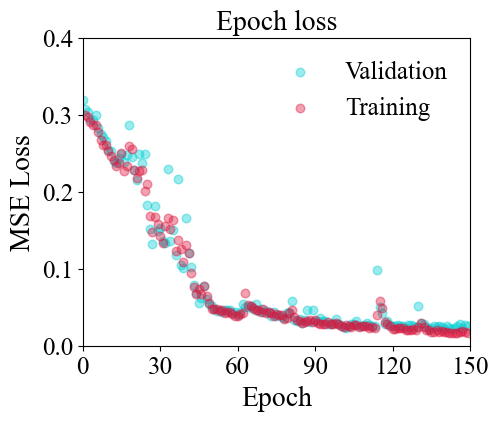

In [22]:
# Epoch_loss = np.loadtxt('./Result/uT_Loss_150.txt')
# valid_loss = Epoch_loss[:, 1]
# train_loss = Epoch_loss[:, 0]
# epochs = 150

plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(facecolor='white', figsize=(5, 4))
plt.xlim(xmax=len(valid_loss), xmin=0)
x1 = [i for i in range(0, len(valid_loss))]
y1 = valid_loss
x2 = [i for i in range(0, len(train_loss))]
y2 = train_loss
colors1 = '#00CED4'
colors2 = '#DC143C'
area = np.pi*4**1.8
plt.scatter(x1, y1, s=area, c=colors1, alpha=0.4, label='Validation')
plt.scatter(x2, y2, s=area, c=colors2, alpha=0.4, label='Training')
plt.title('Epoch loss', fontsize=20)
plt.xlim(0, epochs)
plt.ylim(0, 0.4)
plt.xticks(np.arange(0, epochs+1, 30), fontsize=18)
plt.yticks(np.arange(0, 0.42, 0.1), fontsize=18)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE Loss', fontsize=20)
plt.legend(frameon=False, loc='upper right', fontsize=18)
fig.savefig("./Result/uT_Loss.jpg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
model = Informer(enc_in, dec_in, c_out, Sequence_length, embed_dim, n_heads, e_layers, d_layers, dropout).to(device)
model.load_state_dict(torch.load('./Result/{}_Model_150.pth'.format(Name)))
model.eval()

C:\Users\Dell\AppData\Local\Temp\ipykernel_27800\3979717715.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_enc = torch.tensor(inputs_enc).float().to(device)
C:\Users\Dell\AppData\Local\Temp\ipykernel_27800\3979717715.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_dec = torch.tensor(inputs_dec).float().to(device)
C:\Users\Dell\AppData\Local\Temp\ipykernel_27800\3979717715.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().to(device)


MSE =  0.01653203
MAE =  0.099532135
R2 Score =  0.9404704356686076


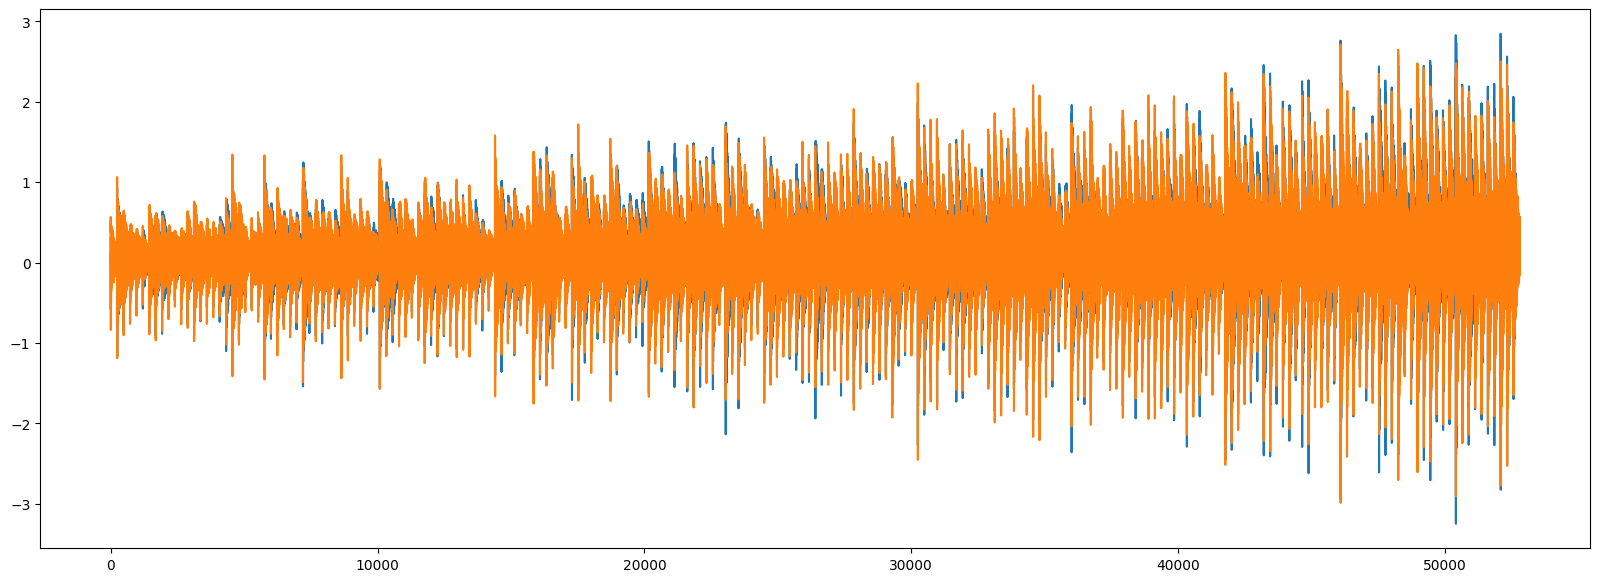

In [14]:
y_pred = []
y_true = []
with torch.no_grad():
    for inputs_enc, inputs_dec, targets in TestDataLoader:
        inputs_enc = torch.tensor(inputs_enc).float().to(device)
        inputs_dec = torch.tensor(inputs_dec).float().to(device)
        targets = torch.tensor(targets).float().to(device)
        outputs = model(inputs_enc, inputs_dec)
        outputs = list(outputs.cpu().numpy().reshape([1, -1])[0])
        targets = list(targets.cpu().numpy().reshape([1, -1])[0])
        y_pred.extend(outputs)
        y_true.extend(targets)

Y = np.zeros((len(y_true), 2))
Y[:, 0] = np.array(y_true)
Y[:, 1] = np.array(y_pred)
np.savetxt('./Result/{}_testY.txt'.format(Name), Y, delimiter=' ')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
Error_mse = mean_squared_error(y_pred, y_true)
Error_mae = mean_absolute_error(y_pred, y_true)
Score = r2_score(y_pred, y_true)
print('MSE = ', Error_mse)
print('MAE = ', Error_mae)
print('R2 Score = ', Score)

fig1 = plt.figure(facecolor='white', figsize=(20, 7))
len_ = [i for i in range(len(y_true))]
plt.plot(len_, y_true, label='y_true')
plt.plot(len_, y_pred, label='y_pred')
plt.show()

In [ ]:
fig2 = plt.figure(facecolor='white', figsize=(20, 7))
len_ = [i for i in range(len(y_true))]
plt.plot(len_[-240*3:], y_true[-240*3:], label='y_true')
plt.plot(len_[-240*3:], y_pred[-240*3:], label='y_pred')
plt.show()